In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [3]:
resolution = 100
nfreq = 100

fcen = 1.75
df = 3.3

# fitting Al

In [4]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000005
Iteration   1, error: 0.000042
Iteration   2, error: 0.000008
Iteration   3, error: 0.000056
Iteration   4, error: 0.000007
Iteration   5, error: 0.000015
Iteration   6, error: 0.000463
Iteration   7, error: 0.000005
Iteration   8, error: 0.000053
Iteration   9, error: 0.000007
Iteration  10, error: 0.000006
Iteration  11, error: 0.000067
Iteration  12, error: 0.000310
Iteration  13, error: 0.000012
Iteration  14, error: 0.002284
Iteration  15, error: 0.000015
Iteration  16, error: 0.000017
Iteration  17, error: 0.000014
Iteration  18, error: 0.000016
Iteration  19, error: 0.000008
Iteration  20, error: 0.000039
Iteration  21, error: 0.000027
Iteration  22, error: 0.000139
Iteration  23, error: 0.000010
Iteration  24, error: 0.000016
Iteration  25, error: 0.000048
Iteration  26, error: 0.000010
Iteration  27, error: 0.000009
Iteration  28, error: 0.000014
Iteration  29, error: 0.000012
Optimal error: 0.000005
Iteration   0, error: 64.226780
Iteration   1,

In [7]:
### ----- Refractive index ----- ###
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor

CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Absorber_layer = 0.5

boundary_layers = [
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.Low),  # 좌측 Absorber
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.High), # 우측 Absorber
    mp.Absorber(thickness=Absorber_layer, direction=mp.Y, side=mp.High), # 상단 Absorber
    
]

In [8]:
Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [16]:
geometry_fitting_Al = [
    # Cathode (하단)
    mp.Block(
        center=Cathode_center,
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=Alq3_center,
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=aNDP_center,
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=ITO_center,
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=Cover_center,
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=Glass_center,
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]



In [17]:
cell_size = mp.Vector3(31, 2, 0)

In [18]:
source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [19]:
# === 시뮬레이션 설정 === #
sim_fitting_Al = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
)

In [20]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting_Al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

sim_fitting_Al.run(until = 50)

net_power_fitting_al = mp.get_fluxes(box_power_fitting_Al)

-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [23]:
frequencies = mp.get_flux_freqs(box_power_fitting_Al)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{net_power_fitting_al[i]:.6e}")

λ (μm)		dipolepower_box (W)
1.4286		6.490472e-03
1.4394		6.783755e-03
1.4502		7.101601e-03
1.4610		7.407166e-03
1.4719		7.736920e-03
1.4827		8.056545e-03
1.4935		8.398575e-03
1.5043		8.734279e-03
1.5152		9.089029e-03
1.5260		9.442696e-03
1.5368		9.810437e-03
1.5476		1.018349e-02
1.5584		1.056417e-02
1.5693		1.095737e-02
1.5801		1.135055e-02
1.5909		1.176396e-02
1.6017		1.216897e-02
1.6126		1.260206e-02
1.6234		1.301826e-02
1.6342		1.347022e-02
1.6450		1.389733e-02
1.6558		1.436740e-02
1.6667		1.480582e-02
1.6775		1.529365e-02
1.6883		1.574467e-02
1.6991		1.625047e-02
1.7100		1.671633e-02
1.7208		1.724091e-02
1.7316		1.772453e-02
1.7424		1.826914e-02
1.7532		1.877377e-02
1.7641		1.933972e-02
1.7749		1.986839e-02
1.7857		2.045661e-02
1.7965		2.101144e-02
1.8074		2.162198e-02
1.8182		2.220364e-02
1.8290		2.283518e-02
1.8398		2.344232e-02
1.8506		2.409186e-02
1.8615		2.472084e-02
1.8723		2.538342e-02
1.8831		2.602808e-02
1.8939		2.669679e-02
1.9048		2.734858e-02
1.9156		2.801457e-02
1.9264

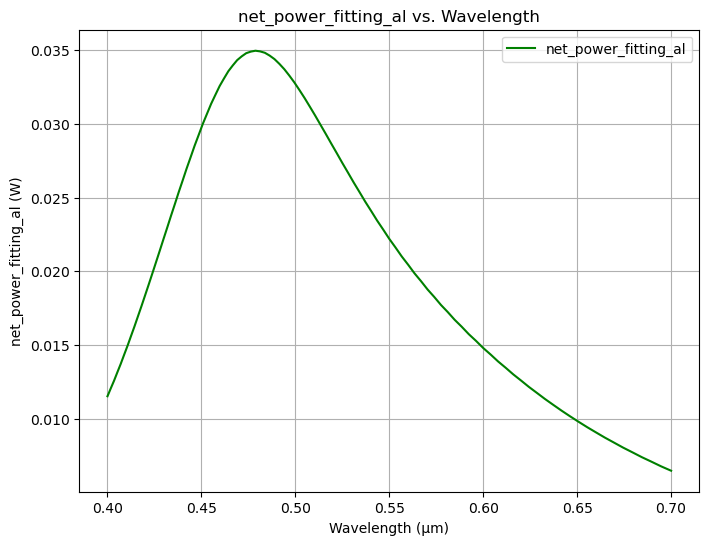

In [24]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power_fitting_al, '-', label='net_power_fitting_al', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('net_power_fitting_al (W)')
plt.title('net_power_fitting_al vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14
# plt.xlim([0.4, 0.7])
plt.legend()
plt.grid(True)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 2.09808e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.6

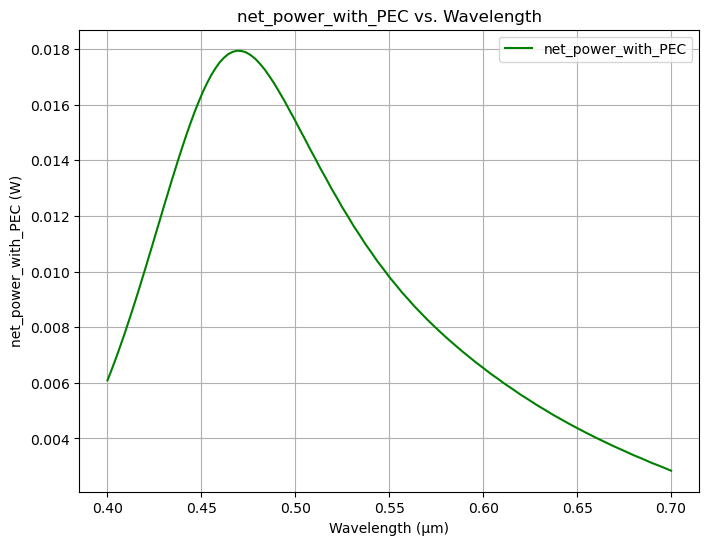

In [25]:
geometry_PEC = [
    # Cathode (하단)
    mp.Block(
        center=Cathode_center,
        size=mp.Vector3(30, Cathode_layer, 0),
        material=mp.perfect_electric_conductor
    ),
    # Alq3
    mp.Block(
        center=Alq3_center,
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=aNDP_center,
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=ITO_center,
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=Cover_center,
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=Glass_center,
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

# === 시뮬레이션 설정 === #
sim_with_PEC = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_PEC,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
)

offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_PEC = sim_with_PEC.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

sim_with_PEC.run(until = 50)

net_power_with_PEC = mp.get_fluxes(box_PEC)

frequencies = mp.get_flux_freqs(box_PEC)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{net_power_with_PEC[i]:.6e}")

plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power_with_PEC, '-', label='net_power_with_PEC', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('net_power_with_PEC (W)')
plt.title('net_power_with_PEC vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14
# plt.xlim([0.4, 0.7])
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [0.7        0.69473684 0.68955224 0.68444444 0.67941176 0.67445255
 0.66956522 0.6647482  0.66       0.65531915 0.65070423 0.64615385
 0.64166667 0.63724138 0.63287671 0.62857143 0.62432432 0.62013423
 0.616      0.61192053 0.60789474 0.60392157 0.6        0.59612903
 0.59230769 0.58853503 0.58481013 0.58113208 0.5775     0.57391304
 0.57037037 0.56687117 0.56341463 0.56       0.55662651 0.55329341
 0.55       0.54674556 0.54352941 0.54035088 0.5372093  0.53410405
 0.53103448 0.528      0.525      0.5220339  0.51910112 0.51620112
 0.51333333 0.51049724 0.50769231 0.50491803 0.50217391 0.49945946
 0.49677419 0.49411765 0.49148936 0.48888889 0.48631579 0.48376963
 0.48125    0.47875648 0.47628866 0.47384615 0.47142857 0.46903553
 0.46666667 0.46432161 0.462      0.45970149 0.45742574 0.45517241
 0.45294118 0.45073171 0.44854369 0.44637681 0.44423077 0.44210526
 0.44       0.43791469 0.43584906 0.43380282 0.4317757  0.42976744
 0.42777778 0.42580645 0.42385321 0.42191781

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 파일은: 2열짜리 [lambda(m), Y] 형식
dipolepower = np.loadtxt("dipolepower.txt", delimiter=",")  # 쉼표 구분자가 아닌 경우 제거해도 됨

lambda_m = dipolepower[:, 0]  # 1열: wavelength in meters
Y = dipolepower[:, 1]         # 2열: normalized power

# 2. 단위 변환: meter → micrometer
lambda_um = lambda_m * 1e6

# 3. 슬라이싱: x 범위 0.4 ~ 0.7 μm
mask = (lambda_um >= 0.4) & (lambda_um <= 0.7)
lambda_sliced = lambda_um[mask]
Y_sliced = Y[mask]

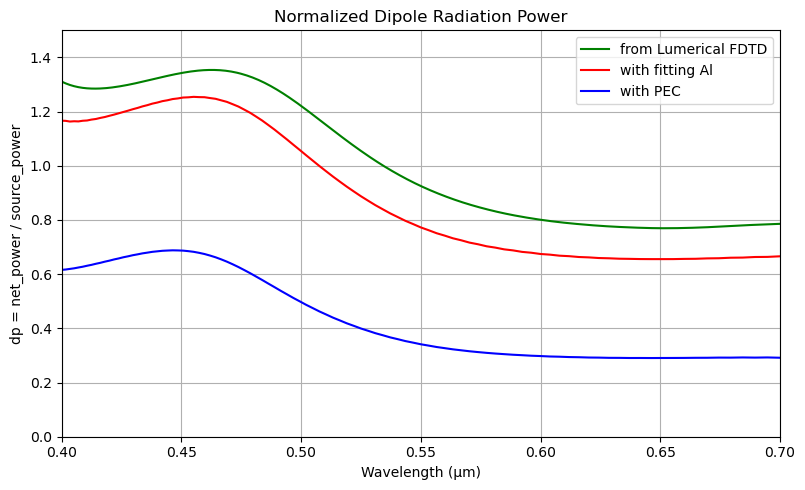

In [32]:
dp_fitting_al = net_power_fitting_al / source_power
dp_PEC = net_power_with_PEC / source_power

# 5. Plot
plt.figure(figsize=(8, 5))

plt.plot(lambda_sliced, Y_sliced, label='from Lumerical FDTD', color='green')  # 🔥 이미지 기반 데이터 추가
plt.plot(wavelengths, dp_fitting_al,  label='with fitting Al', color='red')
plt.plot(wavelengths, dp_PEC,  label='with PEC', color='blue')


plt.xlabel("Wavelength (μm)")
plt.ylabel("dp = net_power / source_power")
plt.title("Normalized Dipole Radiation Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.yscale("log")

plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()